## 时间事件日志

个人时间统计工具。要点：

* 使用 dida365.com 来作为 GTD 工具
* 使用特殊格式记录事件类别和花费的时间，如： “*[探索发现] 体验 iMac 开发环境 [3h]*”
* 导出数据
* 分析数据

### 读取数据

分析并读取数据

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.font_manager import FontManager
import subprocess    

def get_support_chinese_font():
    fm = FontManager()
    mat_fonts = set(f.name for f in fm.ttflist)

    output = subprocess.check_output('fc-list :lang=zh -f "%{family}\n"', shell=True)
    print '*' * 10, '系统可用的中文字体', '*' * 10
    print output
    zh_fonts = set(f.split(',', 1)[0] for f in output.split('\n'))
    available = mat_fonts & zh_fonts

    print '*' * 10, '可用的中文字体', '*' * 10
    for f in available:
        print f
    return available

In [3]:
from matplotlib.pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [4]:
def _date_parser(dstr):
    return pd.Timestamp(dstr).date()

data = pd.read_csv('data/dida365.csv', header=3, index_col='Due Date', parse_dates=True, date_parser=_date_parser)
data.head()

,List Name,Title,Content,Is Checklist,Reminder,Repeat,Priority,Status,Completed Time,Order,Timezone,Is All Day
Due Date,,,,,,,,,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],NaN,N,NaN,NaN,0,2,2016-05-25T14:15:10+0000,-235295488344064,Asia/Shanghai,True
2016-05-23,自我成长,[编程] javascript exercism [0.5h],NaN,N,NaN,NaN,0,2,2016-05-24T15:59:08+0000,-234195976716288,Asia/Shanghai,True
2016-05-23,自我成长,[编程] clojure ring request [2h],阅读 ring.util.request 源码\r,N,NaN,NaN,0,2,2016-05-24T15:58:56+0000,-233096465088512,Asia/Shanghai,True
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],NaN,N,NaN,NaN,0,2,2016-05-23T15:03:24+0000,-231996953460736,Asia/Shanghai,True
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h],iMac 的屏幕体验很棒，但使用非SSD硬盘速度上和mpb想着非常多。\r,N,NaN,NaN,0,2,2016-05-23T14:33:35+0000,-230897441832960,Asia/Shanghai,True


### 数据清洗

* 只关心己完成或己达成的事件，即 `status != 0` 的事件
* 只需要 `List Name` 和 `Title` 字段

In [5]:
df = data[data['Status'] != 0].loc[:, ['List Name', 'Title']]
df.head()

,List Name,Title
Due Date,,
2016-05-24,自我成长,[编程] javascript exercism [1h]
2016-05-23,自我成长,[编程] javascript exercism [0.5h]
2016-05-23,自我成长,[编程] clojure ring request [2h]
2016-05-22,自我成长,[编程] clojure ring 入门 [30m]
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h]


### 数据解析

解析事件类别和和花费的时间

In [6]:
import re

def parse_tag(value):
    m = re.match(r'^(\[(.*?)\])?.*$', value)
    if m and m.group(2):
        return m.group(2)
    else:
        return '其他'

def parse_duration(value):
    m = re.match(r'^.+?\[(.*?)([hm]?)\]$', value)
    if m:
        dur = 0
        try:
            dur = float(m.group(1))
        except e:
            print('parse duration error: \n%s' % e)
        if m.group(2) != 'm':
            dur = dur * 60
        return int(dur)
    else:
        return 0
    
titles = df['Title']
df['Tag'] = titles.map(parse_tag)
df['Duration'] = titles.map(parse_duration)
df.head()

,List Name,Title,Tag,Duration
Due Date,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],编程,60
2016-05-23,自我成长,[编程] javascript exercism [0.5h],编程,30
2016-05-23,自我成长,[编程] clojure ring request [2h],编程,120
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],编程,30
2016-05-22,自我成长,[探索发现] 体验 iMac 开发环境 [3h],探索发现,180


In [7]:
df.count()

List Name    232
Title        232
Tag          232
Duration     232
dtype: int64

In [8]:
start_date = df.index.min().date()
start_date

datetime.date(2015, 12, 2)

In [9]:
end_date = df.index.max().date()
end_date

datetime.date(2016, 5, 24)

### 数据分析

#### 时间总览

平均每天投资在自己身上的时间是多少？-> *全部时间 / 总天数*

In [10]:
end_date - start_date

datetime.timedelta(174)

In [11]:
df['Duration'].sum() 

28932

In [12]:
df['Duration'].sum() / (end_date - start_date).days

166

#### 精力分配

In [13]:
tag_list = df.groupby(['Tag']).sum()
tag_list

,Duration
Tag,
写作,2940
探索发现,3270
机器学习,2010
电影,3048
编程,14604
阅读,3060


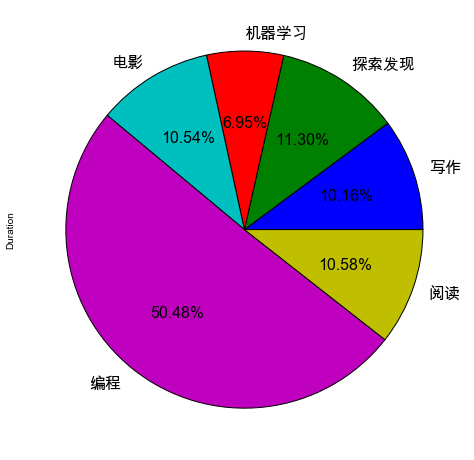

In [14]:
tag_list['Duration'].plot(kind='pie', figsize=(8, 8), fontsize=16, autopct='%1.2f%%')

#### 专注力

长时间学习某项技能的能力

In [15]:
programming = df[df['Tag'] == '编程']
programming.head()

,List Name,Title,Tag,Duration
Due Date,,,,
2016-05-24,自我成长,[编程] javascript exercism [1h],编程,60
2016-05-23,自我成长,[编程] javascript exercism [0.5h],编程,30
2016-05-23,自我成长,[编程] clojure ring request [2h],编程,120
2016-05-22,自我成长,[编程] clojure ring 入门 [30m],编程,30
2016-05-22,自我成长,[编程] javascript exercism [0.5h],编程,30


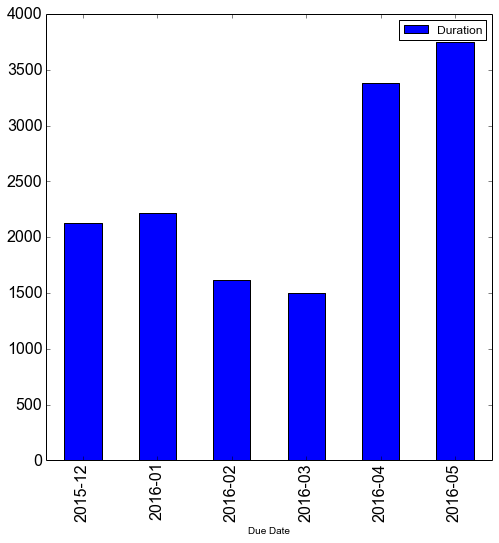

In [16]:
programming.resample('m', how='sum').to_period(freq='m').plot(kind='bar', figsize=(8, 8), fontsize=16)

In [17]:
df.pivot_table(index=['Tag', 'Title'])

Duration
Tag  Title                                             
写作   [写作] scikit-learn 机器学习入门 [2h]                  120
     [写作] scikit-learn 机器学习实例入门教程 [2h]              120
     [写作] stanford cs224d lecture 2 笔记 [3h]         180
     [写作] 《K 均值算法》[1h]                               60
     [写作] 《scikit-learn 机器学习入门》 目录编写 [2h]           120
     [写作] 《主成份分析算法 PCA》 [1.5h]                       90
     [写作] 《使用 kitabu 生成高颜值电子书》 [1h]                  60
     [写作] 《十二公民》观后感 [1h]                             60
     [写作] 《支持向量机核函数》[4h]                            240
     [写作] 写年终总结 [2h]                                120
     [写作] 博客《文艺地解读贝叶斯定理》[2h]                        120
     [写作] 博客《时间事件日志》[1h]                             60
     [写作] 博客《词典的存储和搜索》[3h]                          180
     [写作] 博客《跑者蓝调》[3h]                              180
     [写作] 培训文档 《使用 sublime + plantuml 画图》[4h]       240
     [写作] 基于协同过滤算法的推荐系统 [1.5h]                       90
     [写作] 如何写一篇高质量的技术博客 [1.5h]                       90
     [写作] 独立思考能力草稿 [2h]                             120
     [写作] 知乎答题 [1h]                                  60
     [写作] mlsl matplotlib 简介 [2.5h]                 150
     [写作] mlsl matplotlib 简介 [2h]                   120
     [写作] mlsl numpy 简介 [3h]                        180
     [写作]《支持向量机 SVM 算法》[3h]                         180
探索发现 [探索发现] GenyMotion win7 安装 [1h]                  60
     [探索发现] kitabu 生成电子书 [4h]                       240
     [探索发现] kitabu 生成的电子书中 LaTeX 公式的显示问题 [2h]       120
     [探索发现] mac os dotfiles [3h]                    180
     [探索发现] vim 学习 [3h]                             180
     [探索发现] vim 查找替换及正则表达式 [1h]                      60
     [探索发现] 体验 iMac 开发环境 [3h]                       180
...                                                 ...
编程   [编程] 研究 python 测试框架 [1h]                        60
     [编程] 课程小结备课 [30m]                               30
     [编程] 课程小结视频剪辑 [1h]                              60
     [编程] 阅读 blinker 开源代码实现 [2h]                    120
     [编程] ipython 介绍视频录制 [30m]                       30
     [编程] 豆瓣登录修改签名视频录制 [4h]                         240
阅读   [阅读] 《Beyond Feelings》 [1h]                     60
     [阅读] 《Beyond Feelings》 [30m]                    30
     [阅读] 《Beyond Feelings》15页 [30m]                 30
     [阅读] 《Beyond Feelings》15－26页 [30m]              30
     [阅读] 《把时间当作朋友》[1h]                              60
     [阅读] 《把时间当作朋友》[4h]                             240
     [阅读] 《时间的朋友》 [1h]                               60
     [阅读] 《李笑来博客》 [2h]                              120
     [阅读] 《松本行弘的程序世界》 [1h]                           60
     [阅读] 《松本行弘的程序世界》 [2h]                          120
     [阅读] 《自我教练》 [2h]                               120
     [阅读] 《自我教练》 [3h]                               180
     [阅读] 《讲量化交易》 [1h]                               60
     [阅读] 《高质量 python 程序的 91 个建议》[1h]                60
     [阅读] 当我谈跑步时我在谈什么 [2h]                          120
     [阅读] 微信，知乎 [1h]                                 60
     [阅读] 数学之美 1-26 [3h]                            180
     [阅读] 时间的朋友 [1h]                                 60
     [阅读] 火星救援 [1h]                                  60
     [阅读] 火星救援 [4h]                                 240
     [阅读] 自我教练 [1h]                                  60
     [阅读] 迷茫时代的明白人 [3h]                             180
     [阅读] 黑客与画家 [2h]                                120
     [阅读]《把时间当朋友》[3h]                               180

[198 rows x 1 columns]